In [1]:
%matplotlib inline
import pandas as pd
from mpl_toolkits.basemap import Basemap
import numpy as np
from utilities import timestamps
from utilities.plotting import equi
from utilities.polygon_selection import get_node_data
from utilities.stats import calc_fmd_stats_with_mc
import matplotlib.pyplot as plt
from scipy import spatial

In [16]:
df = pd.read_csv('data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])

In [18]:
df['timestamp'] = df.decimal_year.apply(timestamps.convert_decimal_year_to_numpy_datetime64)

In [19]:
# # foreshock_time = '2016-04-14 12:26:00'
# mainshock_time = '2016-04-15 16:24:28'

start_date = '2001-10-01 00:00:00'
df = df[df.timestamp >= start_date]

# df = df[df.timestamp >= '2000-01-01 00:00:00']
# df = df[df.timestamp >= '2001-10-01 00:00:00']
# df = df[df.timestamp < foreshock_time]
df = df[df.depth <= 40]

In [20]:
df = df.set_index('timestamp')

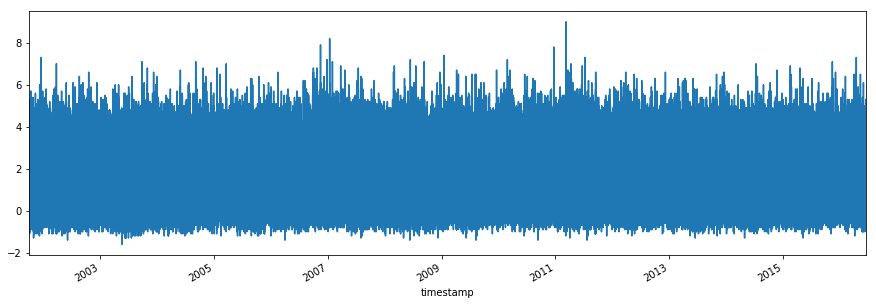

In [21]:
df.mag.plot(figsize=(15,5))

In [22]:
df.tail()

,lon,lat,decimal_year,month,day,mag,depth,hour,minute,second,horizontal_error,depth_error,mag_err
timestamp,,,,,,,,,,,,,
2016-06-16 14:48:12.349991,140.573333,40.191333,2016.457969,6.0,16.0,0.4,8.73,14.0,48.0,12.349998,0.608044,1.08,NaN
2016-06-16 14:48:21.740004,141.505333,36.332167,2016.457970,6.0,16.0,1.7,36.00,14.0,48.0,21.739997,2.702737,NaN,NaN
2016-06-16 14:50:31.579997,138.086167,35.939667,2016.457974,6.0,16.0,0.8,11.01,14.0,50.0,31.579997,0.248167,0.43,NaN
2016-06-16 14:52:44.579989,141.005667,41.915500,2016.457978,6.0,16.0,1.1,9.29,14.0,52.0,44.580003,0.843848,0.91,NaN
2016-06-16 14:52:44.999999,138.706167,37.747000,2016.457978,6.0,16.0,0.6,19.17,14.0,52.0,44.999999,0.760020,0.87,NaN


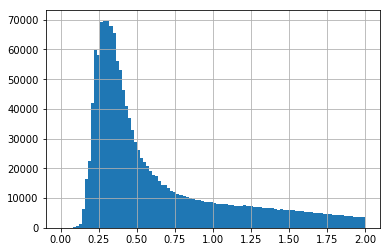

In [23]:
df.horizontal_error.hist(bins=100, range=(0,2))

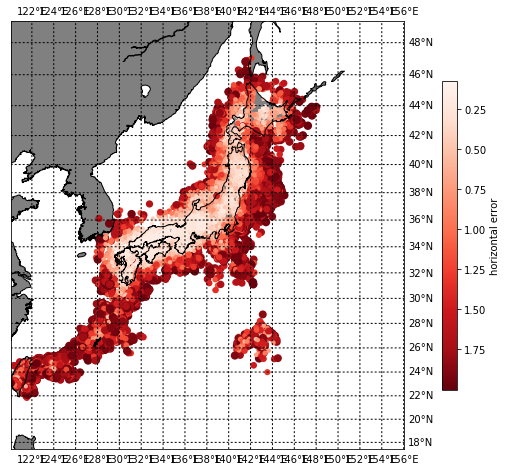

In [24]:
fig, ax = plt.subplots(1, figsize=(8,8))

m = Basemap(projection='merc'
           ,llcrnrlat=df.lat.min()
           ,urcrnrlat=df.lat.max()
           ,llcrnrlon=df.lon.min()
           ,urcrnrlon=df.lon.max()
           ,resolution='i'
           ,area_thresh=1000
           ,ax=ax)

labels = np.arange(0,180,2)
m.drawparallels(labels, labels=labels)
m.drawmeridians(labels, labels=labels)

m.drawcoastlines()
m.fillcontinents(color='gray', zorder=0)

d = df[(df.mag > 2)].copy()
d = d[d.horizontal_error <= 2.0]


x, y = m(d.lon.values, d.lat.values)

cbar = ax.scatter(x, y, c=d.horizontal_error.values, s=10*np.exp(d.horizontal_error.values), edgecolor='None'
                  , cmap='Reds')
c1 = fig.colorbar(cbar, label='horizontal error',fraction=0.0346, pad=0.084)
c1.ax.invert_yaxis()

In [25]:
m_standard = Basemap(projection='merc', lon_0=0)

def get_cumdist(data):
    hist, edges = np.histogram(a=data, bins=100, range=(0,10))
    chist = np.cumsum(hist[::-1])
    return edges, hist, chist

def plot_data_with_fit_line(ax, raw_data, chist, radius, **kwargs):
    a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
    label = radius + ', b={b}, mc={mc}, n={n}'.format(b=round(b,4),mc=mc,n=n)
    ax.scatter(chist[0][::-1][:-1], chist[2], label=label, **kwargs)
#     a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
    x = np.arange(0, 10, 0.1)
    y = 10**(a - b * x)
    ax.plot(x, y, color='black')

def create_grid(axis_1_min_max, axis_2_min_max, axis_3_min_max
                , axis_1_increment, axis_2_increment, axis_3_increment\
               , columns=['longitude', 'latitude', 'depth']):
    axis_1_min, axis_1_max = axis_1_min_max
    axis_2_min, axis_2_max = axis_2_min_max
    axis_3_min, axis_3_max = axis_3_min_max

    axis_1_numpoints = (axis_1_max - axis_1_min)/axis_1_increment + 1
    axis_2_numpoints = (axis_2_max - axis_2_min)/axis_2_increment + 1
    axis_3_numpoints = (axis_3_max - axis_3_min)/axis_3_increment + 1


    axis_1 = np.linspace(axis_1_min, axis_1_max, axis_1_numpoints)
    axis_2 = np.linspace(axis_2_min, axis_2_max, axis_2_numpoints)
    axis_3 = np.linspace(axis_3_min, axis_3_max, axis_3_numpoints)

    axis123 = list(product(axis_1, axis_2, axis_3))
    grid = pd.DataFrame(axis123, columns=columns)
    return grid

def get_node_data(node, radius, data, m=m_standard):
#     m = Basemap(projection='robin', lon_0=0)
    node_lon = node[0]
    node_lat = node[1]
    radius = radius
    distance_from_node = (radius + 10)/111.133
    data = data[data.lon.between(node_lon-distance_from_node, node_lon+distance_from_node)
              & data.lat.between(node_lat-distance_from_node, node_lon+distance_from_node)].copy()
    xy = np.array(m(data.lon.values, data.lat.values)).transpose()
    node_xy = np.array([m(node_lon, node_lat)])
#     dist = scipy.spatial.distance.cdist(xy, node_xy)/1000. #cdist is meters, we want km
    dist = spatial.distance.cdist(xy, node_xy)/1000. #cdist is meters, we want km
    data['distance'] = dist[:,0]
    data = data[data.distance <= radius]
    return data

def mc_maximum_curvature(magnitudes):
    """
    :param catalog : pandas Series
    :param method : string
    """
    minimum = round(magnitudes.min(), 2)
    bins = np.arange(start=minimum, stop=10, step=0.1)
    hist, edges = np.histogram(a=magnitudes, range=(minimum, 10), bins=bins)
    hist_maximum_index = np.argmax(hist)
    return round(edges[hist_maximum_index], 2)

def fmd_values(magnitudes, bin_width=0.1):
    """
    params magnitudes : numpy.array
    params bin_width : float

    returns a,b,bstd, n-values if above the earthquake count threshold
    else returns np.nans
    """
    length = magnitudes.shape[0]
    minimum = magnitudes.min()
    average = magnitudes.mean()
    b_value = (1 / (average - (minimum - (bin_width / 2)))) * np.log10(np.exp(1))

    square_every_value = np.vectorize(lambda x: x ** 2)
    b_stddev = square_every_value((magnitudes - average).sum()) / (length * (length - 1))
    b_stddev = 2.3 * np.sqrt(b_stddev) * b_value ** 2
    a_value = np.log10(length) + b_value * minimum

    return a_value, b_value, b_stddev, length

def calc_fmd_stats_with_mc(magnitudes):
    if len(magnitudes) > 0:
        mc = mc_maximum_curvature(magnitudes) + 0.2
        magnitudes = magnitudes[magnitudes >= mc]
        if len(magnitudes) > 0:
            fmd_stats = fmd_values(magnitudes)
            return fmd_stats + (mc,)
        else: return (np.nan, np.nan, np.nan, np.nan, np.nan)
    else:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
    
def node_pipeline(node, data, radius):
    node_data = get_node_data(node=node, data=data, radius=radius)
    statistics = calc_fmd_stats_with_mc(node_data.mag)
    return statistics

def grid_statistic_pipeline(grid, data, radius):
    stats = []
    for node in grid:
        stats.append(node_pipeline(node=node, data=data, radius=radius) + (node[0], node[1]))
    return np.array(stats)

In [42]:
# d = df[df.lon.between(130,132) & df.lat.between(32,34)].copy()
d = df.copy()

In [45]:
from itertools import product
new_index = [x for x in product(lon_i, lat_i)]

In [46]:
bdf = grid_statistic_pipeline(grid=new_index, data=d[d.mag > 0.5].copy(), radius=5)
#start time 13:33 -> 13:14

/home/max/anaconda2/envs/pymap27/lib/python2.7/site-packages/ipykernel/__main__.py:78: RuntimeWarning: invalid value encountered in divide


In [47]:
bdf = pd.DataFrame(bdf, columns=['a','b','bstd','n','mc', 'lon', 'lat'])

In [48]:
# bdf[bdf.n < 50][['a','b','bstd','n','mc']] = np.nan
#df.loc[df['A'] > 2, 'B'] = new_val
bdf.loc[bdf['n'] < 50, ['a','b','bstd','n','mc']] = np.nan

In [49]:
bdf.describe()

,a,b,bstd,n,mc,lon,lat
count,29396.000000,29396.000000,2.939600e+04,29396.000000,29396.000000,2.973451e+06,2.973451e+06
mean,3.121478,0.829697,1.242267e-15,210.081406,1.256606,1.380000e+02,3.350000e+01
std,0.518710,0.221285,2.973985e-15,435.537374,0.488532,1.039808e+01,9.532053e+00
min,2.030212,0.253361,0.000000e+00,50.000000,0.800000,1.200000e+02,1.700000e+01
25%,2.737692,0.680053,2.639360e-16,68.000000,0.800000,1.290000e+02,2.524000e+01
50%,3.038144,0.821262,6.268894e-16,102.000000,1.100000,1.380000e+02,3.350000e+01
75%,3.418752,0.959524,1.344540e-15,190.000000,1.600000,1.470000e+02,4.176000e+01
max,6.499974,3.096708,1.337430e-13,12870.000000,3.200000,1.560000e+02,5.000000e+01


In [52]:
bdf.to_csv('b_all_japan.csv', index=False)

In [3]:
bdf = pd.read_csv('b_all_japan.csv')

In [ ]:
def plot_dist_with_1sigma(df, ax, **kwargs):
    ax 

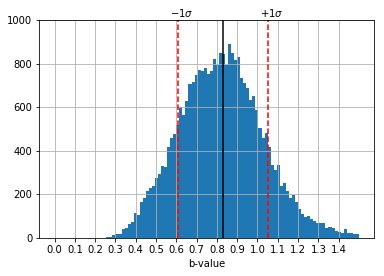

In [4]:
ax = bdf.b.hist(bins=100, range=(0.0,1.5))
lowsigma = bdf.b.mean() - bdf.b.std()
highsigma = bdf.b.mean() + bdf.b.std()
avg = bdf.b.mean()
ax.plot((lowsigma,lowsigma), (0, 1000), color='red', linestyle='--')
ax.plot((highsigma,highsigma), (0, 1000), color='red', linestyle='--')
ax.plot((avg, avg), (0,1000), color='black')
ax.set_ylim(0,1000)
ax.set_xlabel('b-value')
ax.set_xticks(np.arange(0,1.5,0.1))
ax.text(x=lowsigma-0.04, y=1015, s=r'$-1\sigma$')
ax.text(x=highsigma-0.04, y=1015, s=r'$+1\sigma$')

/home/max/anaconda2/envs/pymap27/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/max/anaconda2/envs/pymap27/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


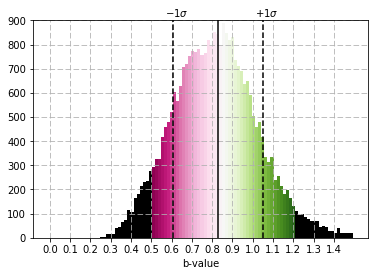

In [5]:
from matplotlib.pyplot import cm 

fig, ax = plt.subplots()

hist, edges = np.histogram(bdf.b.values, bins=100, range=(0, 1.5))
for n, e, h in zip(range(100), edges[:-1], hist):
    if e >= 0.5 and e <= 1.2:
#         print(e,n, n-34)
        color = cm.PiYG((n-34)/46.)
    else:
        color='black'
    ax.bar(e, h, width=0.015, color=color)
ax.grid(True, linestyle='--')
ax.set_xticks(np.arange(0,1.5,0.1))

ax.plot((lowsigma,lowsigma), (0, 900), color='black', linestyle='--')
ax.plot((highsigma,highsigma), (0, 900), color='black', linestyle='--')
ax.plot((avg, avg), (0,900), color='black')
ax.set_ylim(0,900)
ax.text(x=lowsigma-0.04, y=915, s=r'$-1\sigma$')
ax.text(x=highsigma-0.04, y=915, s=r'$+1\sigma$')

ax.set_xlabel('b-value')

In [7]:
1.2-0.5

0.7

In [8]:
edges

array([ 0.   ,  0.015,  0.03 ,  0.045,  0.06 ,  0.075,  0.09 ,  0.105,
        0.12 ,  0.135,  0.15 ,  0.165,  0.18 ,  0.195,  0.21 ,  0.225,
        0.24 ,  0.255,  0.27 ,  0.285,  0.3  ,  0.315,  0.33 ,  0.345,
        0.36 ,  0.375,  0.39 ,  0.405,  0.42 ,  0.435,  0.45 ,  0.465,
        0.48 ,  0.495,  0.51 ,  0.525,  0.54 ,  0.555,  0.57 ,  0.585,
        0.6  ,  0.615,  0.63 ,  0.645,  0.66 ,  0.675,  0.69 ,  0.705,
        0.72 ,  0.735,  0.75 ,  0.765,  0.78 ,  0.795,  0.81 ,  0.825,
        0.84 ,  0.855,  0.87 ,  0.885,  0.9  ,  0.915,  0.93 ,  0.945,
        0.96 ,  0.975,  0.99 ,  1.005,  1.02 ,  1.035,  1.05 ,  1.065,
        1.08 ,  1.095,  1.11 ,  1.125,  1.14 ,  1.155,  1.17 ,  1.185,
        1.2  ,  1.215,  1.23 ,  1.245,  1.26 ,  1.275,  1.29 ,  1.305,
        1.32 ,  1.335,  1.35 ,  1.365,  1.38 ,  1.395,  1.41 ,  1.425,
        1.44 ,  1.455,  1.47 ,  1.485,  1.5  ])

In [9]:
for x in enumerate(zip(edges[:-1], hist)):
    print(x)
    break

(0, (0.0, 0))


In [10]:
lon_i = np.linspace(120, 156, (156-120)*50+1).round(4)
lon_i.shape

lat_i = np.linspace(17, 50, (50-17)*50+1).round(4)
lat_i.shape

(1651,)

In [11]:
lon_i = np.linspace(120, 156, (156-120)*50+1).round(4)
lon_i.shape

lat_i = np.linspace(14, 50, (50-14)*50+1).round(4)
lat_i.shape

(1801,)

In [12]:
lon_i.shape

(1801,)

In [13]:
lon_i = np.linspace(np.floor(bdf.lon.min()), np.ceil(bdf.lon.max()), (np.ceil(bdf.lon.max()) - np.floor(bdf.lon.min()))*50+1)

In [14]:
lat_i = np.linspace(np.floor(bdf.lat.min()), np.ceil(bdf.lat.max()), (np.ceil(bdf.lat.max()) - np.floor(bdf.lat.min()))*50+1)

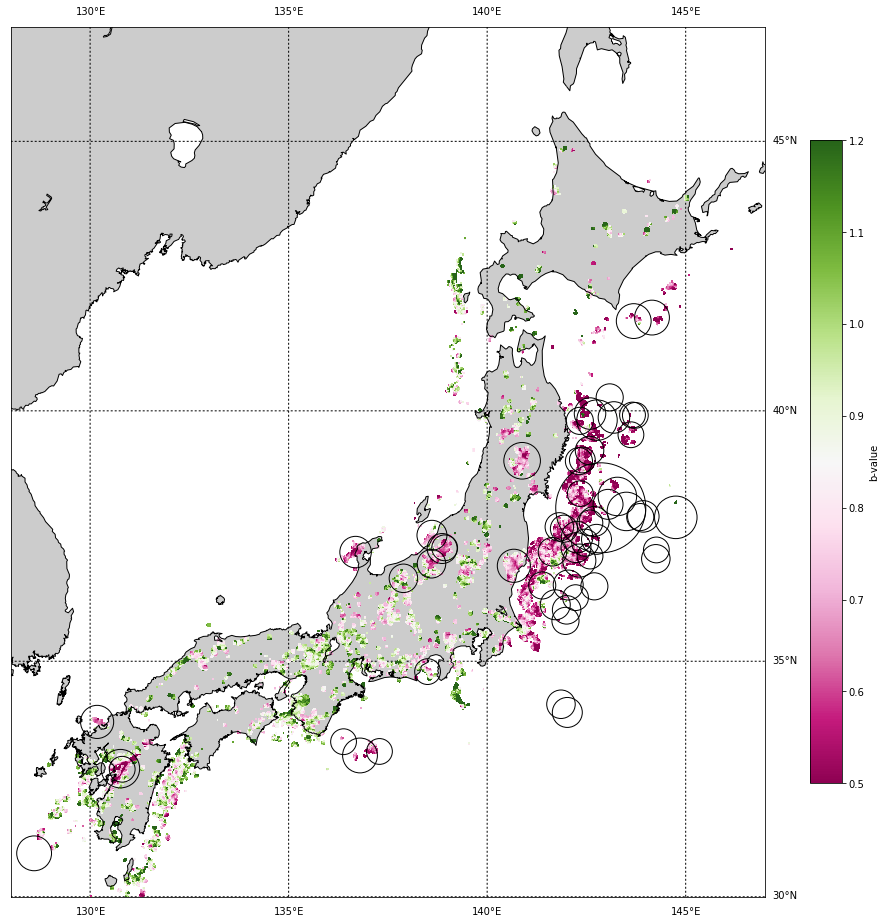

In [26]:
from matplotlib.colors import LogNorm

zi = bdf.pivot(index='lat', columns='lon', values='b').values

fig, ax = plt.subplots(figsize=(16, 16))

m = Basemap(projection='merc'
        , llcrnrlat=30       # the LOWER LEFT corner of latitude
        , urcrnrlat=47        # the UPPER RIGHT corner of latitude
        , llcrnrlon=128      # the LOWER LEFT corner of longitude
        , urcrnrlon=147
        , resolution='i'
        , ax=ax)

lines = np.arange(0,180,5)
m.drawparallels(lines, labels=lines)
m.drawmeridians(lines, labels=lines)

xi, yi = np.meshgrid(lon_i, lat_i)

xi, yi = m(xi, yi)

zi = np.ma.masked_invalid(zi)

m.drawcoastlines(zorder=50)
m.fillcontinents()

cbar = ax.pcolormesh(xi, yi, zi, cmap='PiYG', zorder=15, vmin=0.5, vmax=1.2)

fig.colorbar(cbar, label='b-value', fraction=0.036, pad=0.05)


greater_than_M = df[df.mag >= 6.5].copy()
x, y = m(greater_than_M.lon.values, greater_than_M.lat.values)
cbar2 = ax.scatter(x, y, s=np.exp(greater_than_M.mag.values), color='None', edgecolors='black', zorder=50)

fig.savefig('all_of_JP.eps')

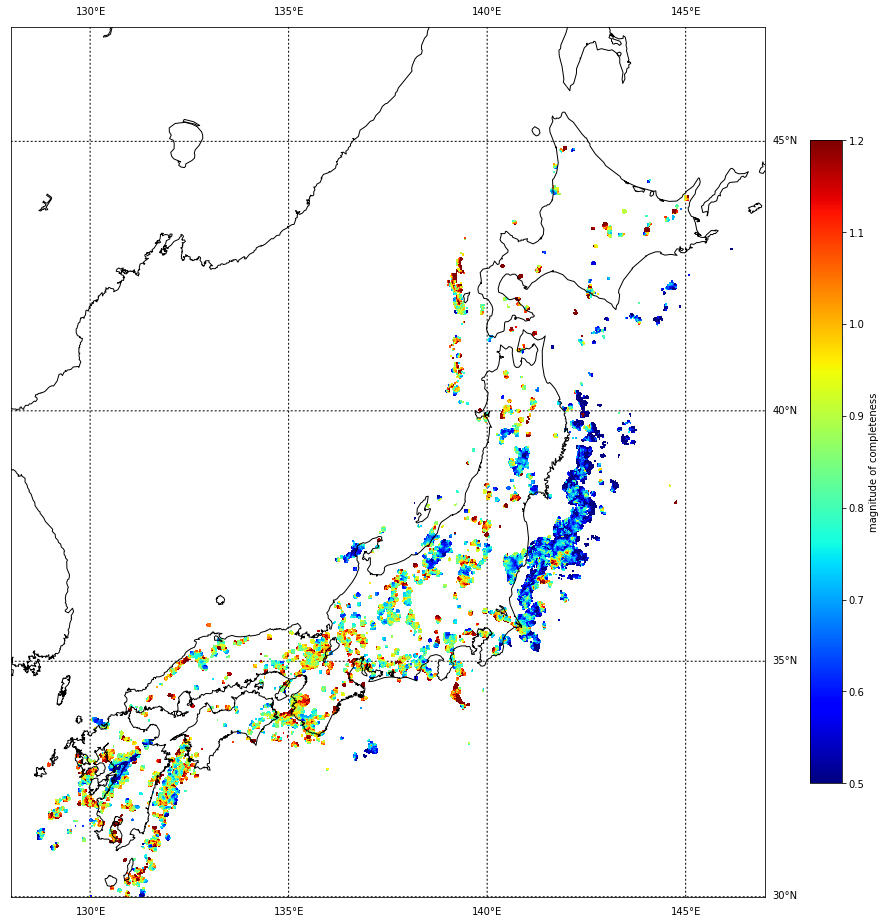

In [210]:
from matplotlib.colors import LogNorm

zi = bdf.pivot(index='lat', columns='lon', values='b').values

fig, ax = plt.subplots(figsize=(16, 16))

m = Basemap(projection='merc'
        , llcrnrlat=30       # the LOWER LEFT corner of latitude
        , urcrnrlat=47        # the UPPER RIGHT corner of latitude
        , llcrnrlon=128      # the LOWER LEFT corner of longitude
        , urcrnrlon=147
        , resolution='i'
        , ax=ax)

lines = np.arange(0,180,5)
m.drawparallels(lines, labels=lines)
m.drawmeridians(lines, labels=lines)

# xi, _yi = m(lon_i, np.zeros_like(lon_i))
# _xi, yi = m(np.zeros_like(lat_i), lat_i)

# x, y = m(lon_i, lat_i)


xi, yi = np.meshgrid(lon_i, lat_i)

xi, yi = m(xi, yi)

zi = np.ma.masked_invalid(zi)

# cbar = ax.pcolormesh(xi, yi, zi, cmap='jet', norm=LogNorm())

m.drawcoastlines(zorder=50)

cbar = ax.pcolormesh(xi, yi, zi, cmap='jet', zorder=15, vmin=0.5, vmax=1.2)

fig.colorbar(cbar, label='magnitude of completeness', fraction=0.036, pad=0.05)


greater_than_M = df[df.mag >= 6.5].copy()
x, y = m(greater_than_M.lon.values, greater_than_M.lat.values)
cbar2 = ax.scatter(x, y, s=np.exp(greater_than_M.mag.values), alpha=0.75, cmap='brg', c=greater_than_M.decimal_year
           , edgecolor='black', linewidth=1.25, zorder=5, )

fig.colorbar(cbar2, label='decimal year', orientation='horizontal')

In [120]:
df[df.mag>=6].describe()

,lon,lat,decimal_year,month,day,mag,depth,hour,minute,second,horizontal_error,depth_error,mag_err
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,124.000000,0.0
mean,140.959986,36.114895,2009.698024,6.003861,15.335907,6.410811,20.700541,10.872587,28.015444,29.834904,4.379588,2.547742,NaN
std,9.392209,7.677002,3.554072,3.469131,7.223931,0.411698,12.188535,6.769401,16.997485,18.161510,4.978168,1.258476,NaN
min,120.449167,19.976667,2001.936586,1.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.299998,0.220399,0.530000,NaN
25%,139.061167,32.721167,2006.876735,3.000000,11.000000,6.100000,9.985000,6.000000,13.500000,13.310000,1.425630,1.477500,NaN
50%,142.465167,37.389667,2011.189710,4.000000,14.000000,6.300000,23.600000,10.000000,26.000000,28.810002,2.275252,2.465000,NaN
75%,144.350583,39.916000,2011.276956,9.000000,20.000000,6.600000,30.000000,17.500000,42.000000,46.195000,4.936546,3.480000,NaN
max,156.046833,48.729000,2016.413714,12.000000,31.000000,9.000000,40.000000,23.000000,59.000000,59.829997,28.457240,4.950000,NaN


In [173]:
def get_cumdist(data):
    hist, edges = np.histogram(a=data, bins=100, range=(0,10))
    chist = np.cumsum(hist[::-1])
    return edges, hist, chist

def plot_data_with_fit_line(ax, raw_data, chist, radius, **kwargs):
    a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
#     label = radius + ', b={b}, mc={mc}, n={n}'.format(b=round(b,4),mc=mc,n=n)
    ax.scatter(chist[0][::-1][:-1], chist[2], **kwargs)
#     a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
    x = np.arange(0, 10, 0.1)
    y = 10**(a - b * x)
    ax.plot(x, y, color='black')

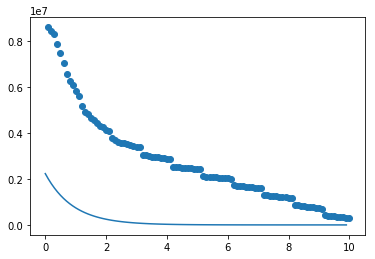

In [189]:
ch = get_cumdist(df)
fig, ax = plt.subplots()
a, b, bstd, n, mc = calc_fmd_stats_with_mc(df.mag)
ax.scatter(ch[0][::-1][:-1], ch[2])
x = np.arange(0,10,0.1)
y = 10**(a - b * x)
ax.plot(x, y)

In [190]:
ch

(array([  0. ,   0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,   0.8,
          0.9,   1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,   1.7,
          1.8,   1.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,   2.6,
          2.7,   2.8,   2.9,   3. ,   3.1,   3.2,   3.3,   3.4,   3.5,
          3.6,   3.7,   3.8,   3.9,   4. ,   4.1,   4.2,   4.3,   4.4,
          4.5,   4.6,   4.7,   4.8,   4.9,   5. ,   5.1,   5.2,   5.3,
          5.4,   5.5,   5.6,   5.7,   5.8,   5.9,   6. ,   6.1,   6.2,
          6.3,   6.4,   6.5,   6.6,   6.7,   6.8,   6.9,   7. ,   7.1,
          7.2,   7.3,   7.4,   7.5,   7.6,   7.7,   7.8,   7.9,   8. ,
          8.1,   8.2,   8.3,   8.4,   8.5,   8.6,   8.7,   8.8,   8.9,
          9. ,   9.1,   9.2,   9.3,   9.4,   9.5,   9.6,   9.7,   9.8,
          9.9,  10. ]),
 array([164020, 110045, 468951, 388972, 427347, 477565, 320016, 179192,
        241821, 213046, 450202, 241865,  88537, 200632,  69441, 116873,
        151506,  48722, 122897,  39759, 315286,  61

# 4 locations from before (low/high b, max slip, hypocenter)

In [24]:
# max_slip = (130.9372, 32.84189)
# fm_main = (130.763, 32.7545)#, 128, 74, -14)
# high_b = (131.25, 33.15,)
# low_b = (130.5, 32.5)

In [25]:
# df_min = df[df.mag > 1.5].copy()

In [26]:
# get_node_data(node=low_b, radius=15, data=df_min).describe()

In [27]:
# df['hz_err_deg'] = df['horizontal_error'] / 111.113

In [28]:
# b_hypo = []
# for r in range(100):
#     loc_err_df = df.copy()
#     loc_err_df['lon'] = loc_err_df['lon'] + np.random.uniform(-1,1) * loc_err_df['horizontal_error']
#     loc_err_df['lat'] = loc_err_df['lat'] + np.random.uniform(-1,1) * loc_err_df['horizontal_error']
#     node_df = get_node_data(node=fm_main, radius=15, data=loc_err_df)
#     a, b, bstd, n, mc = calc_fmd_stats_with_mc(node_df.mag)
#     b_hypo.append(b)

In [29]:
# def generate_b_based_on_location_error(df, location, radius):
#     err_df = df.copy()
#     err_df['lon'] = err_df['lon'] + np.random.uniform(-1, 1) * err_df['hz_err_deg']
#     err_df['lat'] = err_df['lat'] + np.random.uniform(-1, 1) * err_df['hz_err_deg']
#     node_df = get_node_data(node=location, radius=radius, data=err_df)
#     a, b, bstd, n, mc = calc_fmd_stats_with_mc(node_df.mag)
#     return a, b, bstd, n, mc

In [30]:
# %timeit generate_b_based_on_location_error(df=df, location=fm_main, radius=15)

# hypocenter b-value distribution

In [31]:
# b10000samples = [generate_b_based_on_location_error(df=df[df.mag>1.5], location=fm_main, radius=15) for x in range(10000)]

In [32]:
# b10000df = pd.DataFrame(np.array(b10000samples), columns=['a','b','bstd','n','mc'])
# ax = b10000df.b.hist(bins=100)
# ax.set_title('hypocenter')

In [33]:
# b10000df.describe()

# low-bvalue

In [34]:
# low_b_10000_samples = [generate_b_based_on_location_error(df=df[df.mag>1.5]
#                                                           , location=low_b, radius=15) for x in range(10000)]

In [35]:
# low_b_10000_samples = pd.DataFrame(np.array(low_b_10000_samples), columns=['a','b','bstd','n','mc'])
# ax = low_b_10000_samples.b.hist(bins=100)
# ax.set_title('low b-value')

# max slip

In [36]:
# max_slip_10000_samples = [generate_b_based_on_location_error(df=df[df.mag>1.5]
#                                                           , location=max_slip, radius=15) for x in range(10000)]

In [37]:
# max_slip_10000_samples = pd.DataFrame(np.array(max_slip_10000_samples), columns=['a','b','bstd','n','mc'])
# ax = max_slip_10000_samples.b.hist(bins=100)
# ax.set_title('max slip')

# high b value

In [38]:
# high_b_10000_samples = [generate_b_based_on_location_error(df=df[df.mag>1.5]
#                                                           , location=high_b, radius=15) for x in range(10000)]

In [39]:
# high_b_10000_samples = pd.DataFrame(np.array(high_b_10000_samples), columns=['a','b','bstd','n','mc'])
# ax = high_b_10000_samples.b.hist(bins=100)
# ax.set_title('low b-value')

In [40]:
# err_df = df.copy()

# %timeit err_df['lon'] = err_df['lon'] + np.random.uniform(-1, 1) * err_df['hz_err_deg']


In [41]:
# err_df['hz_err_deg'].describe()

In [42]:
# pd.DataFrame(b_hypo).hist()

In [43]:
# def generate_b_based_on_location_error(df, samples, location, radius):
#     b_hypo = []
#     for r in range(samples):
#         loc_err_df = df.copy()
#         loc_err_df = get_node_data(node=location, radius=radius, data=loc_err_df)
#         loc_err_df['lon'] = loc_err_df['lon'] + np.random.uniform(-1,1) * loc_err_df['hz_err_deg']
#         loc_err_df['lat'] = loc_err_df['lat'] + np.random.uniform(-1,1) * loc_err_df['hz_err_deg']
# #         node_df = get_node_data(node=location, radius=radius, data=loc_err_df)
#         a, b, bstd, n, mc = calc_fmd_stats_with_mc(loc_err_df.mag)
#         b_hypo.append(b)
#     return np.array(b_hypo)

In [44]:
# b_hypo

In [45]:
# hypo_b = generate_b_based_on_location_error(df=df, samples=10000, location=fm_main, radius=15)

In [46]:
# hypo_b

In [47]:
# (1.6/10*10000)/60